In [6]:
import os
import imageio
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy import stats, signal
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
import seaborn as sns

## Lectura de los datasets

In [7]:
def abrir_imagenes(path):
    imagen_ant_em=np.flipud(imageio.imread(path + 'ANT_EM.dcm'))
    imagen_ant_sc=np.flipud(imageio.imread(path + 'ANT_SC.dcm'))
    imagen_pos_em=np.flipud(imageio.imread(path + 'POST_EM.dcm'))
    imagen_pos_sc=np.flipud(imageio.imread(path + 'POST_SC.dcm'))
    meta=imagen_ant_em.meta
    imagen=np.stack((imagen_ant_em,imagen_ant_sc,imagen_pos_em,imagen_pos_sc))
    return imagen, meta

In [10]:
path_dicom_1='./DISTINTOSTIEMPOS/1h/'
path_dicom_15='./DISTINTOSTIEMPOS/15h/'
path_dicom_40='./DISTINTOSTIEMPOS/40h/'
path_dicom_64='./DISTINTOSTIEMPOS/64h/'

In [11]:
imagen_1, meta_1=abrir_imagenes(path_dicom_1)
imagen_15, meta_15=abrir_imagenes(path_dicom_15)
imagen_40, meta_40=abrir_imagenes(path_dicom_40)
imagen_64, meta_64=abrir_imagenes(path_dicom_64)
pos=['ANT_EM','ANT_SC','POST_EM','POST_SC']

* imagen_x guarda los valores de los pixels
* meta_x guarda los meta valores para la imágen EM (son iguales para cada imágen)
* Para cada tiempo la imágen se compone a su vez de 4 imágenes: Anterior EM y SC, y Posterior EM y SC
* Las imágenes se guardan en un tensor donde cada z corresponde a una imánes en el siguiente orden: 
  * ANT_EM [0,:,:]
  * ANT_SC [1,:,:]
  * POST_EM [2,:,:]
  * POST_SC [3,:,:]

In [18]:
n0,n1=meta_1.shape #Tamaño de la imágen
d0,d1=meta_1.sampling #dimension del pixel
x = np.arange(0.0, (n0+1)*d0, d0)
y = np.arange(0.0, (n1+1)*d1, d1)
print ('Las imágnes tienen',n0,'pixeles de alto','y',n1,'pixeles de ancho')
print ('Los pixeles miden',d0,'mm x', d1,'mm')

Las imágnes tienen 1024 pixeles de alto y 256 pixeles de ancho
Los pixeles miden 2.20903 mm x 2.20903 mm


Las imágenes se han tomado con diferentes tiempos de aquision entonces se normalizan por el valor del tiempo de adquision para que sean comparables entre si. Además se consideran que los valores de los pixeles no han sido transformado a actividad sino que representan el número de cuentas en el detector. 

In [20]:
imagen_norm_1=imagen_1/np.float(meta_1.AcquisitionTime)
imagen_norm_15=imagen_15/np.float(meta_15.AcquisitionTime)
imagen_norm_40=imagen_40/np.float(meta_40.AcquisitionTime)
imagen_norm_64=imagen_64/np.float(meta_64.AcquisitionTime)
maximos=[np.max([imagen_norm_1[0,:,:],imagen_norm_15[0,:,:],imagen_norm_40[0,:,:],imagen_norm_64[0,:,:]]),
         np.max([imagen_norm_1[1,:,:],imagen_norm_15[1,:,:],imagen_norm_40[1,:,:],imagen_norm_64[1,:,:]]),
         np.max([imagen_norm_1[2,:,:],imagen_norm_15[2,:,:],imagen_norm_40[2,:,:],imagen_norm_64[2,:,:]]),
         np.max([imagen_norm_1[3,:,:],imagen_norm_15[3,:,:],imagen_norm_40[3,:,:],imagen_norm_64[3,:,:]])]

## 1. Encuentre en cada caso la distribución de los valores de cada pixel y su evolución en el tiempo.

In [21]:
plt.figure(16,figsize=((d1*n1/0.0393701)/1000,(d0*n0/0.0393701)/1000))
j=0
for i in [1,5,9,13]:
    plt.subplot(4,4,i)
    plt.pcolormesh(y,x,imagen_norm_1[j,:,:],cmap='hot',vmax=maximos[j])
    plt.colorbar(orientation='horizontal',shrink=0.9)
    plt.axis('off')
    plt.title('1 hora')
    plt.subplot(4,4,i+1)
    plt.pcolormesh(y,x,imagen_norm_15[j,:,:],cmap='hot',vmax=maximos[j])
    plt.colorbar(orientation='horizontal',shrink=0.9)
    plt.axis('off')
    plt.title('15 horas')
    plt.subplot(4,4,i+2)
    plt.pcolormesh(y,x,imagen_norm_40[j,:,:],cmap='hot',vmax=maximos[j])
    plt.colorbar(orientation='horizontal',shrink=0.9)
    plt.axis('off')
    plt.title('40 horas')    
    plt.subplot(4,4,i+3)
    plt.pcolormesh(y,x,imagen_norm_64[j,:,:],cmap='hot',vmax=maximos[j])
    plt.colorbar(orientation='horizontal',shrink=0.9)
    plt.axis('off')
    plt.title('64 horas')
    j+=1
plt.show()

## 2. Realizar análisis de estadística descriptiva sobre los datos, tanto en una como en múltiples variables. Moda, media, mediana y desviación estándar de un producto en particular.

In [23]:
def descripcion_estadistica(data):
    data=data[np.nonzero(data)]
    mediana=np.median(data)
    media=np.mean(data)
    desv_std=np.std(data)
    moda=stats.mode(data,axis=None)
    resultado=[mediana, media, desv_std, np.asscalar(moda.mode), np.asscalar(moda.count)] 
    return resultado

In [24]:
estadistica_1=np.zeros((4,5))
estadistica_15=np.zeros((4,5))
estadistica_40=np.zeros((4,5))
estadistica_64=np.zeros((4,5))
for i in range(0,4):
        estadistica_1[i,]=(descripcion_estadistica(imagen_norm_1[i,:,:]))
        estadistica_15[i,]=(descripcion_estadistica(imagen_norm_15[i,:,:]))
        estadistica_40[i,]=(descripcion_estadistica(imagen_norm_40[i,:,:]))
        estadistica_64[i,]=(descripcion_estadistica(imagen_norm_64[i,:,:]))
h=['1','15','40','64']
for i in range(0,4):
    for j in range(0,4):
        print('Imágen',h[i],'horas',pos[j])
        print('              Mediana:', '{:.4e}'.format(eval('estadistica_'+h[i]+'['+str(j)+','+str(0)+']')))
        print('                Media:', '{:.4e}'.format(eval('estadistica_'+h[i]+'['+str(j)+','+str(1)+']')))
        print('   Deviación estandár:', '{:.4e}'.format(eval('estadistica_'+h[i]+'['+str(j)+','+str(2)+']')))
        print('                 Moda:', '{:.4e}'.format(eval('estadistica_'+h[i]+'['+str(j)+','+str(3)+']')))
        print('         Cuentas moda:', '{:.0f}'.format(eval('estadistica_'+h[i]+'['+str(j)+','+str(4)+']')))
        print('------------------------------------------------')

Imágen 1 horas ANT_EM
              Mediana: 8.8008e-05
                Media: 1.3436e-04
   Deviación estandár: 3.3055e-04
                 Moda: 5.8672e-06
         Cuentas moda: 22129
------------------------------------------------
Imágen 1 horas ANT_SC
              Mediana: 1.1734e-05
                Media: 2.2201e-05
   Deviación estandár: 2.4678e-05
                 Moda: 5.8672e-06
         Cuentas moda: 34251
------------------------------------------------
Imágen 1 horas POST_EM
              Mediana: 8.2140e-05
                Media: 1.1711e-04
   Deviación estandár: 1.6690e-04
                 Moda: 5.8672e-06
         Cuentas moda: 23590
------------------------------------------------
Imágen 1 horas POST_SC
              Mediana: 1.1734e-05
                Media: 2.0601e-05
   Deviación estandár: 1.8668e-05
                 Moda: 5.8672e-06
         Cuentas moda: 35737
------------------------------------------------
Imágen 15 horas ANT_EM
              Mediana: 5.5119e-

A continuación se hace un bolxplot teniendo en cuenta los píxels con valor 0 (correspondientes al fondo de la imágen y que no agregan demasiada información) y desestimando los valores de pixel iguales a cero para comparar. Como se ve, cuando se hace un drop de los valores de píxel 0, el valor Q3 - Q1 se incrementa. 

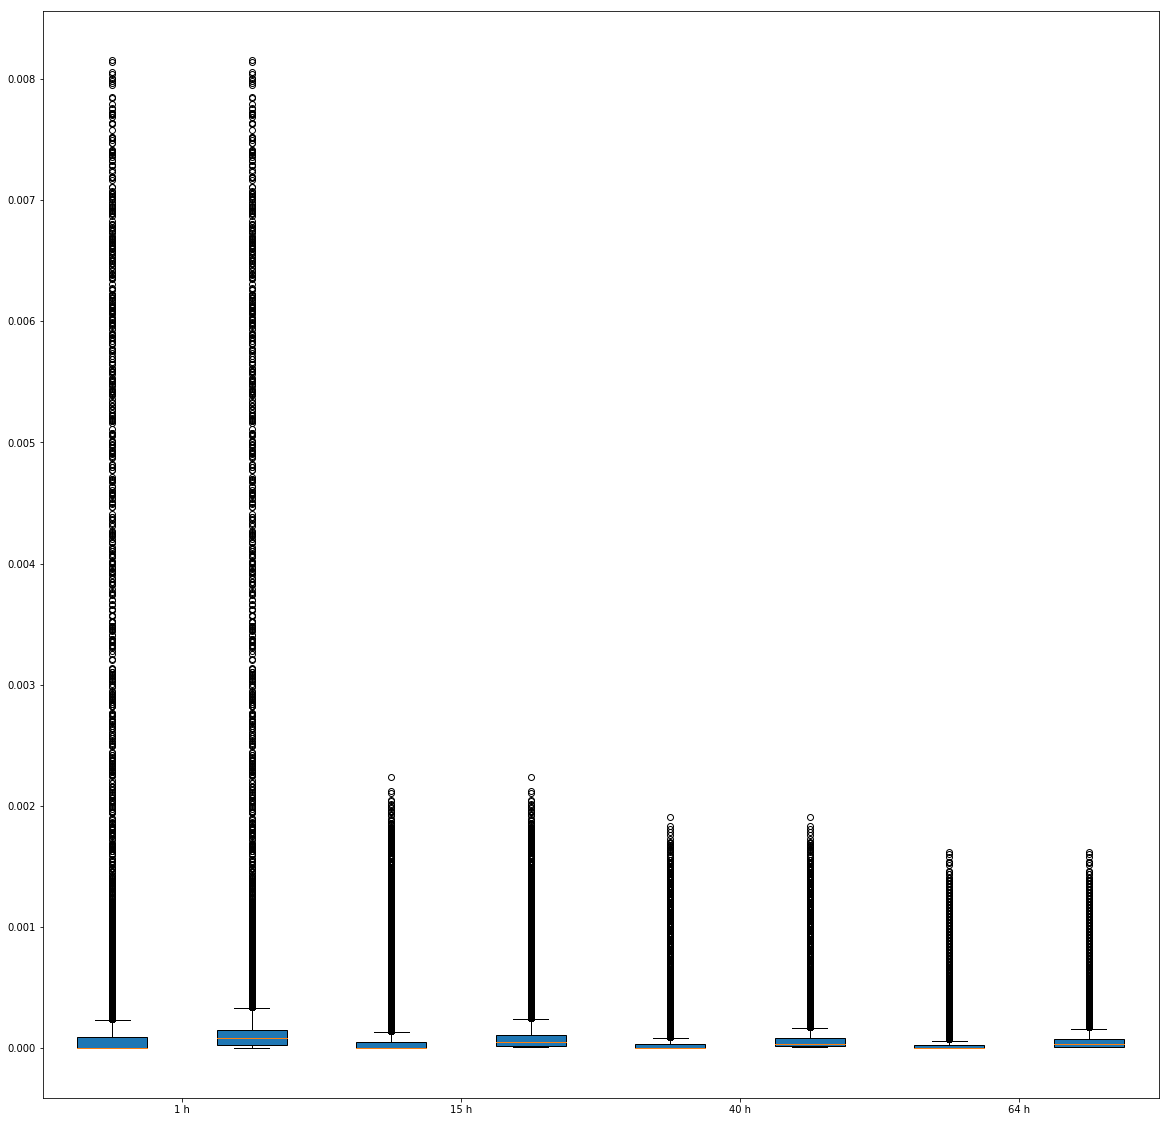

In [25]:

plt.figure(figsize=(20,20))
plt.boxplot([np.ravel(imagen_norm_1[0,:,:]),
             np.ravel(imagen_norm_15[0,:,:]),
             np.ravel(imagen_norm_40[0,:,:]),
             np.ravel(imagen_norm_64[0,:,:]),
             imagen_norm_1[0][np.nonzero(imagen_norm_1[0,:,:])],
             imagen_norm_15[0][np.nonzero(imagen_norm_15[0,:,:])],
             imagen_norm_40[0][np.nonzero(imagen_norm_40[0,:,:])],
             imagen_norm_64[0][np.nonzero(imagen_norm_64[0,:,:])]],
             patch_artist=True,positions=[0,2,4,6,1,3,5,7])

plt.xticks([0.5,2.5,4.5,6.5],['1 h' ,'15 h' ,'40 h' ,'64 h'])
plt.show()

## 3 .Defina de alguna forma la información que pueda considerarse “ruido” y encuentre outliers.##

A continuación se genera una grilla sobre una de las imágenes para obtener regiones que puedan resultarnos de interés. 

In [11]:
plt.figure(16,figsize=((d1*n1/0.0393701)/1000,(d0*n0/0.0393701)/1000))
plt.pcolormesh(imagen_norm_1[0,:,:],cmap='jet',vmax=maximos[0])
#plt.colorbar(orientation='horizontal')
plt.axis('on')
plt.grid(which='both')
plt.xticks(np.arange(0,256,step=10))
plt.yticks(np.arange(0,1024,step=10))

([<matplotlib.axis.YTick at 0x151efad1c358>,
 <a list of 103 Text yticklabel objects>)

A partir de la imágen anterior definimos 3 regios de interes (ROI). REO1 derecha e izquierda (correspondiente a pulmones), ROI2 correspondiente a vejiga, y ROI3 y ROI4 que podríamos considerar como fondo. A continuación, se enmarcan las regiones nombradas. 

In [33]:
#roi_1_d=[1024-770, 1024-670, 256-130, 256-60]
#roi_1_i=[1024-770, 1024-670, 256-195, 256-135]
roi_1_d=[670, 770, 135, 195]
roi_1_i=[670, 770, 70, 130]
roi_2=[560, 600, 96, 146]
roi_3=[610, 660, 95, 145]
roi_4=[860, 880,120, 140]

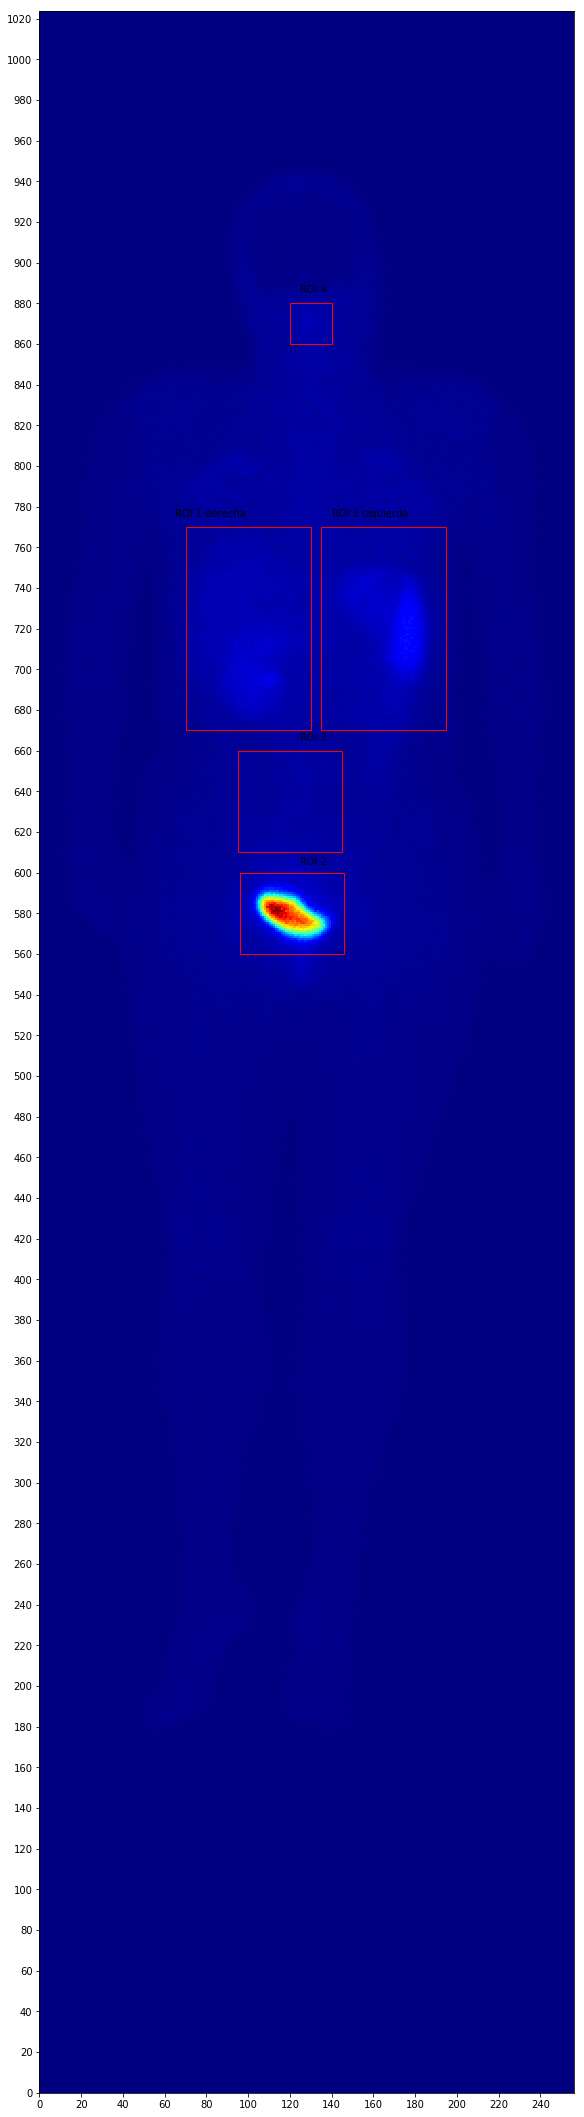

In [34]:

plt.figure(16,figsize=((d1*n1/0.0393701)/1500,(d0*n0/0.0393701)/1500))
plt.pcolormesh(imagen_norm_1[0,:,:],cmap='jet',vmax=maximos[0])
plt.axis('on')
#plt.grid(which='both')
plt.xticks(np.arange(0,256,step=20))
plt.yticks(np.arange(0,1024,step=20))

ax = plt.gca()
patches=[]

# Creo un Rectangle patch para cada ROI
roi1i = mpatches.Rectangle((70,670),60,100)
plt.text(140,775,'ROI 1 izquierda')
patches.append(roi1i)

roi1d = mpatches.Rectangle((135,670),60,100)
plt.text(65,775,'ROI 1 derecha')
patches.append(roi1d)

roi2 = mpatches.Rectangle((96,560),50,40)
plt.text(125,1024-420,'ROI 2')
patches.append(roi2)

roi3 = mpatches.Rectangle((95,610),50,50)
plt.text(125,665,'ROI 3')
patches.append(roi3)

roi4 = mpatches.Rectangle((120,860),20,20)
plt.text(125,885,'ROI 4')
patches.append(roi4)

collection = PatchCollection(patches,facecolor='none',edgecolor='r')
ax.add_collection(collection)

In [35]:
R1_d_imagen_1=imagen_norm_1[0,roi_1_d[0]:roi_1_d[1],roi_1_d[2]:roi_1_d[3]]
R1_i_imagen_1=imagen_norm_1[0,roi_1_i[0]:roi_1_i[1],roi_1_i[2]:roi_1_i[3]]
R2_imagen_1=imagen_norm_1[0,roi_2[0]:roi_2[1],roi_2[2]:roi_2[3]]
R3_imagen_1=imagen_norm_1[0,roi_3[0]:roi_3[1],roi_3[2]:roi_3[3]]
R4_imagen_1=imagen_norm_1[0,roi_4[0]:roi_4[1],roi_4[2]:roi_4[3]]

R1_d_imagen_15=imagen_norm_15[0,roi_1_d[0]:roi_1_d[1],roi_1_d[2]:roi_1_d[3]]
R1_i_imagen_15=imagen_norm_15[0,roi_1_i[0]:roi_1_i[1],roi_1_i[2]:roi_1_i[3]]
R2_imagen_15=imagen_norm_15[0,roi_2[0]:roi_2[1],roi_2[2]:roi_2[3]]
R3_imagen_15=imagen_norm_15[0,roi_3[0]:roi_3[1],roi_3[2]:roi_3[3]]
R4_imagen_15=imagen_norm_15[0,roi_4[0]:roi_4[1],roi_4[2]:roi_4[3]]

R1_d_imagen_40=imagen_norm_40[0,roi_1_d[0]:roi_1_d[1],roi_1_d[2]:roi_1_d[3]]
R1_i_imagen_40=imagen_norm_40[0,roi_1_i[0]:roi_1_i[1],roi_1_i[2]:roi_1_i[3]]
R2_imagen_40=imagen_norm_40[0,roi_2[0]:roi_2[1],roi_2[2]:roi_2[3]]
R3_imagen_40=imagen_norm_40[0,roi_3[0]:roi_3[1],roi_3[2]:roi_3[3]]
R4_imagen_40=imagen_norm_40[0,roi_4[0]:roi_4[1],roi_4[2]:roi_4[3]]

R1_d_imagen_64=imagen_norm_64[0,roi_1_d[0]:roi_1_d[1],roi_1_d[2]:roi_1_d[3]]
R1_i_imagen_64=imagen_norm_64[0,roi_1_i[0]:roi_1_i[1],roi_1_i[2]:roi_1_i[3]]
R2_imagen_64=imagen_norm_64[0,roi_2[0]:roi_2[1],roi_2[2]:roi_2[3]]
R3_imagen_64=imagen_norm_64[0,roi_3[0]:roi_3[1],roi_3[2]:roi_3[3]]
R4_imagen_64=imagen_norm_64[0,roi_4[0]:roi_4[1],roi_4[2]:roi_4[3]]

Como ruido, tomamos la media de valor de los píxels contenidos en las ROI3 y ROI4 más tres desvíos standar.

In [36]:
ruido=np.concatenate((np.ravel(R3_imagen_1),np.ravel(R4_imagen_1)),axis=None)
promedio_ruido=np.mean(ruido)
bkg=promedio_ruido+3*np.std(ruido)

In [37]:
R1_d_imagen_1_lim=R1_d_imagen_1*(R1_d_imagen_1>bkg)*1.0
R1_i_imagen_1_lim=R1_i_imagen_1*(R1_i_imagen_1>bkg)*1.0
R2_imagen_1_lim=R2_imagen_1*(R2_imagen_1>bkg)*1.0
R3_imagen_1_lim=R3_imagen_1*(R3_imagen_1>bkg)*1.0
R4_imagen_1_lim=R4_imagen_1*(R4_imagen_1>bkg)*1.0

R1_d_imagen_15_lim=R1_d_imagen_15*(R1_d_imagen_15>bkg)*1.0
R1_i_imagen_15_lim=R1_i_imagen_15*(R1_i_imagen_15>bkg)*1.0
R2_imagen_15_lim=R2_imagen_15*(R2_imagen_15>bkg)*1.0
R3_imagen_15_lim=R3_imagen_15*(R3_imagen_15>bkg)*1.0
R4_imagen_15_lim=R4_imagen_15*(R4_imagen_15>bkg)*1.0

R1_d_imagen_40_lim=R1_d_imagen_40*(R1_d_imagen_40>bkg)*1.0
R1_i_imagen_40_lim=R1_i_imagen_40*(R1_i_imagen_40>bkg)*1.0
R2_imagen_40_lim=R2_imagen_40*(R2_imagen_40>bkg)*1.0
R3_imagen_40_lim=R3_imagen_40*(R3_imagen_40>bkg)*1.0
R4_imagen_40_lim=R4_imagen_40*(R4_imagen_40>bkg)*1.0

R1_d_imagen_64_lim=R1_d_imagen_64*(R1_d_imagen_64>bkg)*1.0
R1_i_imagen_64_lim=R1_i_imagen_64*(R1_i_imagen_64>bkg)*1.0
R2_imagen_64_lim=R2_imagen_64*(R2_imagen_64>bkg)*1.0
R3_imagen_64_lim=R3_imagen_64*(R3_imagen_64>bkg)*1.0
R4_imagen_64_lim=R4_imagen_64*(R4_imagen_64>bkg)*1.0

In [38]:
imagen_norm_1_lim=imagen_norm_1*(imagen_norm_1>bkg)*1.0
imagen_norm_15_lim=imagen_norm_15*(imagen_norm_15>bkg)*1.0
imagen_norm_40_lim=imagen_norm_40*(imagen_norm_40>bkg)*1.0
imagen_norm_64_lim=imagen_norm_64*(imagen_norm_64>bkg)*1.0

A la izquierda observamos la imagen de la vejiga limpia, y a la derecha la normal.

<Figure size 432x288 with 0 Axes>

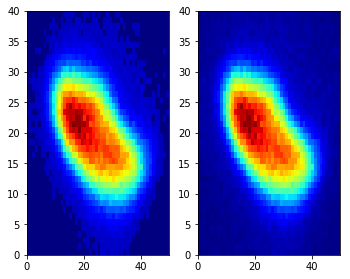

In [39]:
l ,h=np.shape(R2_imagen_1_lim)
plt.figure()
plt.subplots(1,2,figsize=((d1*h/0.0393701)/500,(d0*l/0.0393701)/500))
plt.subplot(1,2,1)
plt.pcolormesh(R2_imagen_1_lim,cmap='jet',vmax=maximos[0])
plt.subplot(1,2,2)
plt.pcolormesh(R2_imagen_1,cmap='jet',vmax=maximos[0])
plt.show()

Las siguientes son las imágenes obtenidas luego de filtrar los valores que señalamos como ruido (izquierda) y sin filtrar los valores considerados como ruido (derecha).

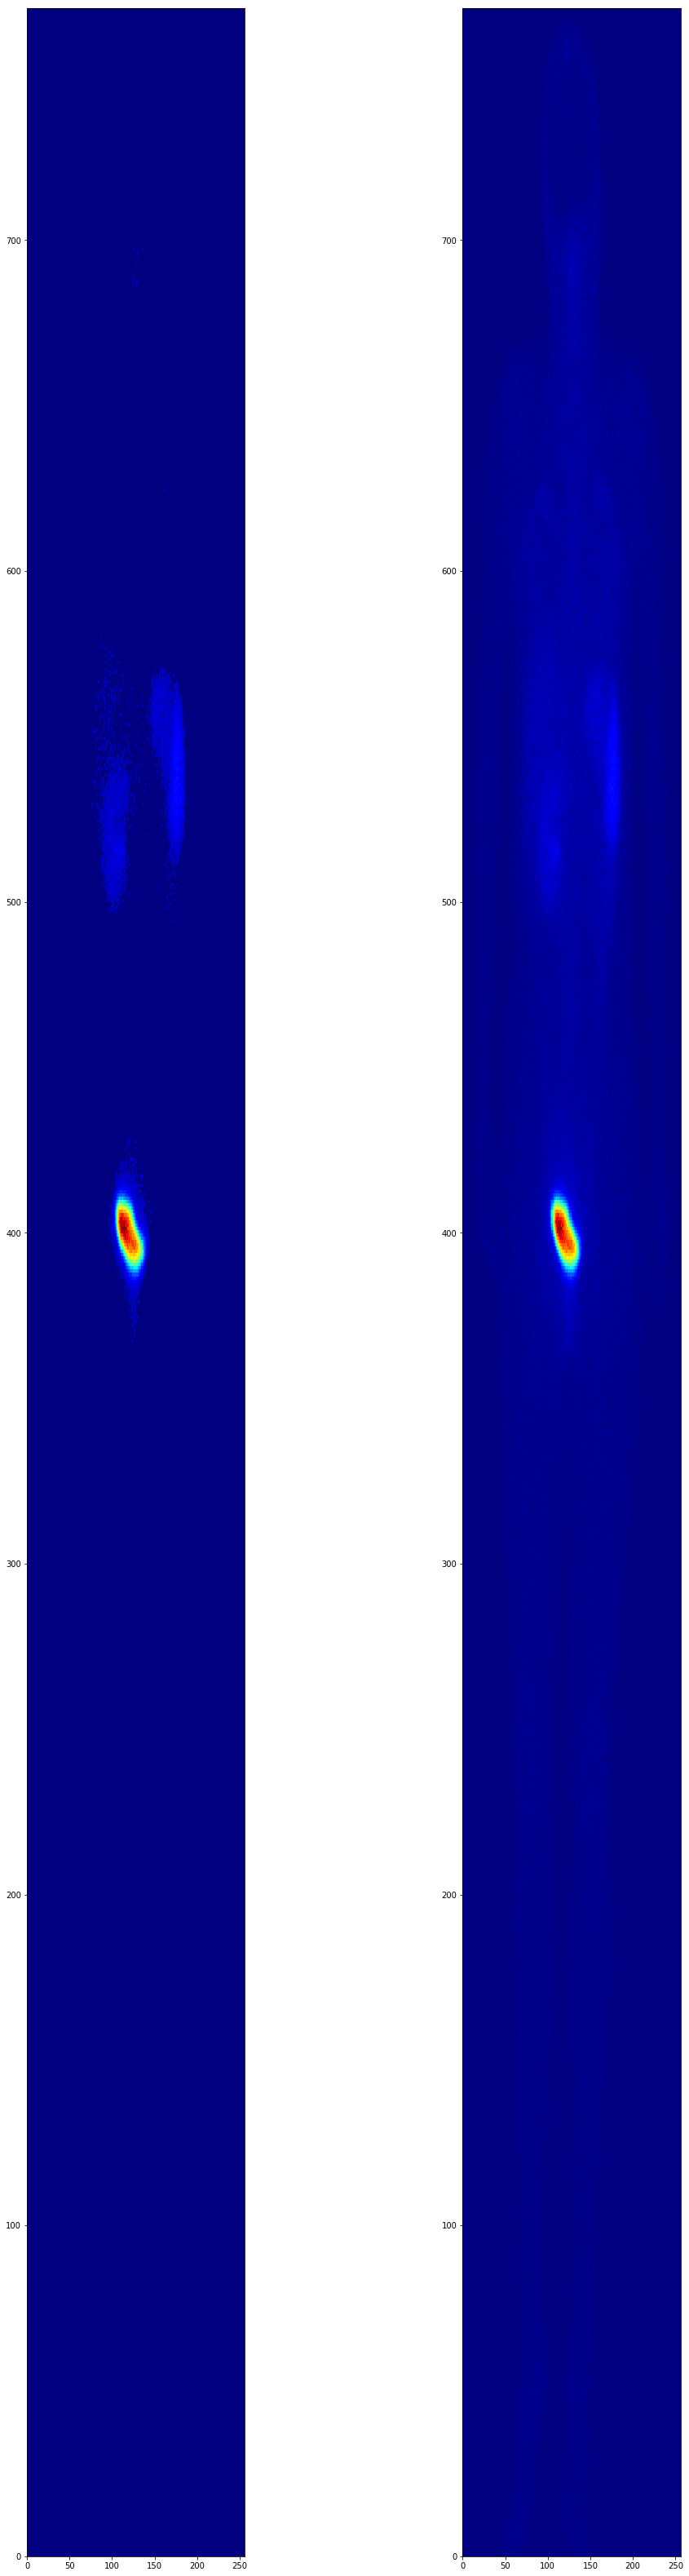

In [45]:
#plt.figure(figsize=(30,30))
plt.figure(figsize=(2*(d1*n1/0.0393701)/2000,2*(d0*n0/0.0393701)/2000))
#plt.subplots(1,2,figsize=((d1*n1/0.0393701)/2000,(d0*n0/0.0393701)/2000))
plt.subplot(1,2,1)
plt.pcolormesh(imagen_norm_1_lim[0,180:950,:],cmap='jet',vmax=maximos[0])
plt.subplot(1,2,2)
plt.pcolormesh(imagen_norm_1[0,180:950,:],cmap='jet',vmax=maximos[0])

plt.subplots_adjust(wspace=1)
plt.show()

A continuación los gráficos de violín de las imágenes sin limpiar (derecha) y limpias (izquierda).

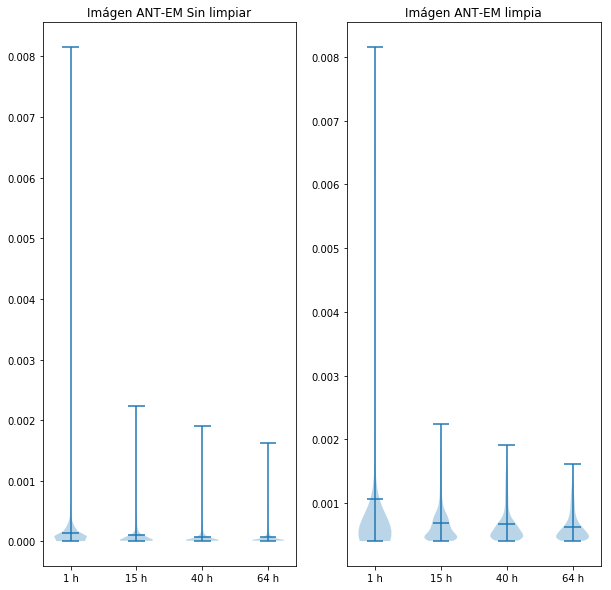

In [46]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.violinplot([imagen_norm_1[0][np.nonzero(imagen_norm_1[0,:,:])],
             imagen_norm_15[0][np.nonzero(imagen_norm_15[0,:,:])],
             imagen_norm_40[0][np.nonzero(imagen_norm_40[0,:,:])],
             imagen_norm_64[0][np.nonzero(imagen_norm_64[0,:,:])]],
             showmeans=True)
plt.xticks([1,2,3,4],['1 h' ,'15 h' ,'40 h' ,'64 h'])
plt.title('Imágen ANT-EM Sin limpiar')

plt.subplot(1,2,2)
plt.violinplot([imagen_norm_1_lim[0][np.nonzero(imagen_norm_1_lim[0,:,:])],
             imagen_norm_15_lim[0][np.nonzero(imagen_norm_15_lim[0,:,:])],
             imagen_norm_40_lim[0][np.nonzero(imagen_norm_40_lim[0,:,:])],
             imagen_norm_64_lim[0][np.nonzero(imagen_norm_64_lim[0,:,:])]],
             showmeans=True)
plt.xticks([1,2,3,4],['1 h' ,'15 h' ,'40 h' ,'64 h'])
plt.title('Imágen ANT-EM limpia')
plt.show()



## 4.Agrupe en un número que considere aceptable los datos de cada imagen y busque coeficientes de correlación entre grupos del mismo tiempo y grupos de distintos tiempos. Definido un conjunto de píxeles dentro de un grupo en la primera imagen, este grupo de píxeles debe pertenecer al mismo grupo en los tiempos siguientes.

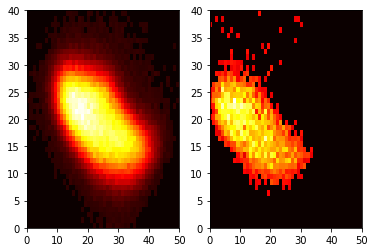

In [29]:
plt.figure()
plt.subplot(1,2,1)
plt.pcolormesh(R2_imagen_1_lim,cmap='hot')
plt.subplot(1,2,2)
plt.pcolormesh(R2_imagen_15_lim,cmap='hot')
plt.figure()
plt.pcolormesh(signal.correlate2d(R2_imagen_1_lim,R2_imagen_15_lim))
plt.colorbar()
plt.show()

## 5.Defina un criterio para poder dividir los datos en cada imagen en sub-regiones que pueda considerar “homogéneas”.

In [71]:
R2_imagen_1_lim.shape

(40, 50)

In [34]:
plt.pcolormesh(R2_imagen_1_lim,cmap='hot')
plt.contour(R2_imagen_1_lim)

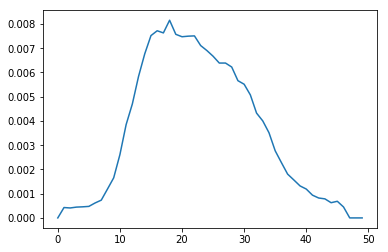

In [36]:
plt.plot(R2_imagen_1_lim[20,:])

Una forma de obtener valores homogeneos de píxels (o demarcar rangos de valores) es haciéndo máscaras. Valiéndonos de las propiedades de numpy esto es muy sencillo.

Vamos a ejemplificar como segmentar con una máscara sobre una imagen. Por ejemplo la imagen imagen_norm_1

Por ejemplo, para filtrar los valores mayores a 0 de la imagen_1 debería hacer lo siguiente:

In [92]:
imagen_1_1 = imagen_1[0]
imagen_1_1 > 0

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

Como observamos, eso nos entrega un array de valores True y False. Si quisiera saber cuántos valores True hay (que se corresponden con los valores mayores a 0) puedo hacer lo siguiente:

In [93]:
len(imagen_1_1[imagen_1_1 > 0])

140621

Lo que hicimos fue filtrar los valores imagen_norm_1 de acuerdo a un array de True y False (el filtro nos devuelve un array con los valores de las posiciones True).

Para establecer valores de pixels entre rangos (por ejemplo entre 500 y 1000) podemos hacer lo siguiente:

In [94]:
(imagen_1_1 > 500) * (imagen_1_1 < 1000)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

La cantidad de píxels dentro de este rango nos da:

In [95]:
len(imagen_1_1[(imagen_1_1 > 500) * (imagen_1_1 < 1000)])

229

Vamos a aplicarlo ahora para segmentar una cierta región de la vejiga. Para ello buscamos los rangos de valores de píxels comprendidos entre 200 y 1200 y los graficamos.

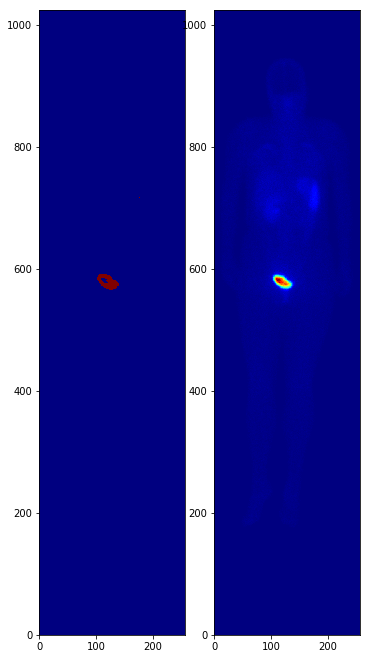

In [115]:
plt.figure(figsize=(2*(d1*n1/0.0393701)/5000,(d0*n0/0.0393701)/5000))

plt.subplot(1, 2, 1)
plt.pcolormesh(((imagen_1_1 > 200) * (imagen_1_1 < 1200)) * 1.,cmap='jet')
plt.subplot(1, 2, 2)
plt.pcolormesh(imagen_1_1,cmap='jet')
#plt.contour(R2_imagen_1_lim)

A la izquierda observamos la imagen segmentada por máscaras y a la derecha la imagen sin segmentar.